In [2]:
cd PycharmProjects/motoki_ul/review_analysis

[Errno 2] No such file or directory: 'PycharmProjects/motoki_ul/review_analysis'
/Users/motoki/PycharmProjects/motoki_ul/review_analysis


In [3]:
##Clean raw data & prepare for analytics

import pandas as pd

input_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/input_dir/lohaco"
df = pd.read_csv(f"{input_dir}/Review_beverage.csv")
df.fillna("。")

category = "紅茶・ハーブティー"
sub_category = "ハーブティー"
sub_category_excl = "ハーブティー（ペットボトル）"

#Rename columns
df.rename(columns={"380_カタログCD": "product_code",
                   "390_WEBユニーク名": "product_name",
                   "840_評価": "review",
                   "841_タイトル": "title",
                   "842_コメント": "comment",
                   "360_WEB小カテゴリ名": "sub-category"}, inplace=True)

#Found NaN in title columns so replaced
df["combined_title"] = df["title"].fillna("。").str.cat(" " + df["comment"])
df_new_raw = pd.concat([df["product_code"], df["product_name"], df["Brand"], df["combined_title"], df["Category"], df["sub-category"]], axis=1)
df_new = df_new_raw.fillna(0)
df_new = df_new[df_new["Category"].str.contains(category)]
df_new = df_new[df_new["sub-category"].str.contains(sub_category)]
df_new = df_new[~df_new["sub-category"].str.contains(sub_category_excl)]
print(df_new)

#Combine comments on each product (for Doc2Vec)
df_new_combined = df_new.groupby(["product_name", "product_code", "Brand"])["combined_title"].sum().reset_index()
print(df_new_combined)

      product_code                                       product_name  \
80         J839306  日東紅茶　水出しピーチティー＆ローズヒップ ティーバッグ　1セット（36バッグ：12バッグ入...   
592        J288499             生活の木 ルイボスバニラモカ 1袋（40ヶ入） ハーブティー（ティーバッグ）   
990         423698                         ポンパドール カモミールティー 1箱（20バッグ入）   
1046       1619636                            成城石井 ガスコ　ルイボスチャイ　1袋30個入   
1047       1619636                            成城石井 ガスコ　ルイボスチャイ　1袋30個入   
...            ...                                                ...   
24576      8878101  山本漢方製薬　山本　カモミール100%　4979654024549　1箱（2g×20包）　ハ...   
24743      X913954  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス...   
24764      1712452            Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）   
24908      P643160      【ワゴンセール】【水出し可】伊藤園 ヘルシールイボスティー 1袋（3.0g×60バッグ入）   
25448      P275553      【水出し可】 伊藤園 お徳用 ヘルシールイボスティー ティーバッグ 1袋（100バッグ入）   

                      Brand  \
80                     日東紅茶   
592                    生活の木   
990       POMPADOUR（ポンパドール）   

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/motoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


        word  count
21        香り     43
34        飲ん     41
16        思い     36
1         購入     34
9        ティー     32
56      美味しい     30
57         味     28
60       やすい     26
20        良い     25
6       美味しく     24
84        飲む     23
50        入れ     22
10        好き     22
11       ハーブ     19
7         お茶     17
90        いい     15
4         あり     14
17       パック     14
65        出し     14
122       いる     13
125  ルイボスティー     13
150       なく     12
42     カフェイン     12
44        なっ     12
30        なり     11
123       入っ     11
95        お湯     11
13        ある     11
48      おいしい     11
55        飲め     10


<Figure size 2160x1440 with 0 Axes>

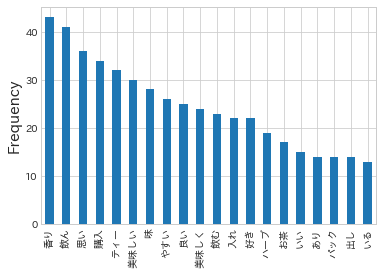

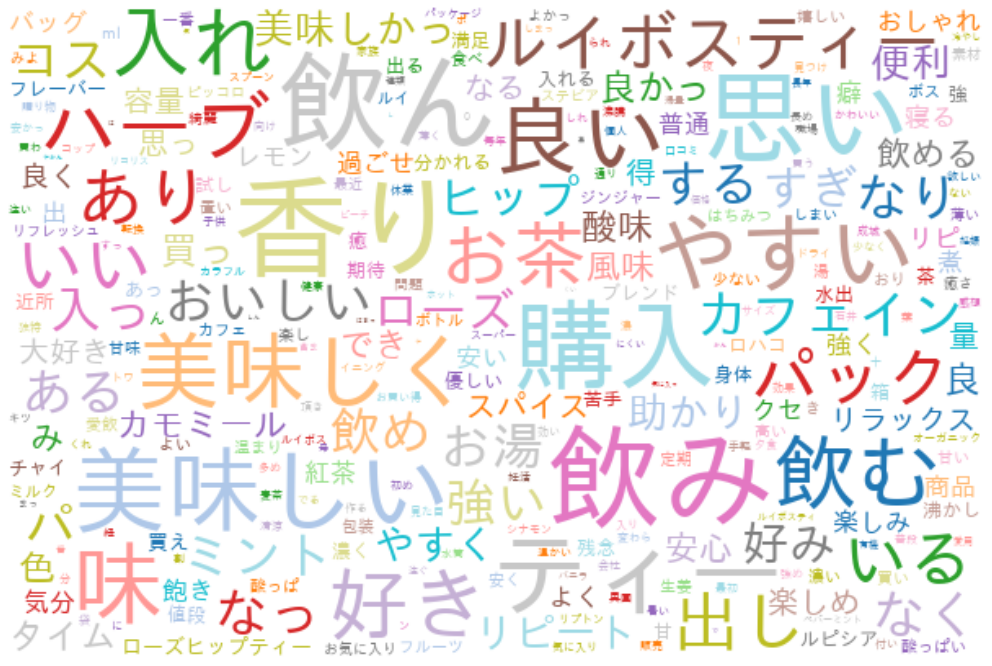

In [43]:
##Split into words and visualize

from sklearn.feature_extraction import stop_words
from collections import Counter, defaultdict
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import MeCab
import sys
import urllib
import nltk
import string
import re
import numpy as np

%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic"

tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
tagger.parse("")

class CustomMeCabTagger(MeCab.Tagger):

    COLUMNS = ["表層形", "品詞", "品詞細分類1", "品詞細分類2", "品詞細分類3", "活用型", "活用形", "原形", "読み", "発音"]

    def parseToDataFrame(self, text: str) -> pd.DataFrame:
        """テキストを parse した結果を Pandas DataFrame として返す"""
        results = []
        #Mecabの出力方式に基づく。(表層系\t品詞,品詞細分類...)
        #まずは改行で分けて単語自体を区分する
        text_unlisted = " ".join([i for item in text for i in item])
        for line in self.parse(text_unlisted).split("\n"):
            #EOS = end of statement, no more words
            if line == "EOS":
                break
            #Split word itself and feature by "tab"
            surface, feature = line.split("\t")
            #Put None if the content is "*" (means nothing)
            feature = [None if f == "*" else f for f in feature.split(",")]
            results.append([surface, *feature])
        return pd.DataFrame(results, columns=type(self).COLUMNS)

def get_dokuritsugo_by_mecab(text):
    tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
    tagger.parse("") 
    node = tagger.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        #only needs below (others don't have meanings in this context)
        if pos in ["名詞", "動詞", "形容詞"]:
            word = node.surface
            word_list.append(word)
        node = node.next
    return " ".join(word_list)

df_new["cleared_words"] = df_new["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))

stop_words_all = []
#define stopword (English)
nltk.download("stopwords")
stop_words_sklearn = stop_words.ENGLISH_STOP_WORDS
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_nltk.extend(stop_words_sklearn)
stop_words_all = stop_words_nltk

#define stopword (Japanese)
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']
stop_words_all.extend(slothlib_stopwords)

#define manual stopword
add_words=["'",u"それ",u"てる",u"よう",u"こと",u"の",u"し",u"い",u"ん",u"さ",u"て",u"せ",u"れ"]
stop_words_all.extend(add_words)

def del_stop_words(text):
    #replace all the punctuations by using re.sub()
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    sample = regex.sub("", text)
    
    #change to lower case and check if it's in stop words list
    words = [w.lower()  for w in sample.split(" ") \
                 if not w.lower()  in stop_words_all]
    words=" ".join(words)
    return words

def del_single_used_words(text):
    #delete words only used once
    frequency = defaultdict(int)
    for words in text:
        for token in words:
            frequency[token] += 1
    words = [[token for token in words if frequency[token] > 1] for words in text]
    return words

df_new["cleared_stopwords"] = list(df_new["cleared_words"].apply(lambda x: del_stop_words(x)))
text = del_single_used_words([i.split(" ") for i in df_new["cleared_stopwords"]])

##Make combined list for doc2vec (now also used for LDA&word2Vec)
df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"]=list(df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x)))
text_combined = del_single_used_words([i.split(" ") for i in df_new_combined["cleared_stopwords"]])

#finally make dataframe of wordlist splitted by MeCab
tagger = CustomMeCabTagger()
result = tagger.parseToDataFrame(text_combined)

counter_list = []
for i in result["表層形"]:
    counter_list.append(i)
word_count = Counter(counter_list)

df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count = df_count.iloc[1:,:]

print(df_count.head(30))

#Visualization for word count graph
plt.figure(figsize = (30,20))
ax=df_count.iloc[:20,:].plot.bar()
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xticklabels(
    df_count.iloc[:20,:]["word"], fontdict = {
        'fontsize':10})
ax.legend_.remove()
plt.style.use('seaborn-whitegrid')
plt.show()

fpath = "/Users/motoki/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
#Visualization for word cloud
wc_bz = WordCloud(
    background_color="white",
    width=600,
    height=400,
    max_words=3000,
    max_font_size=70,
    font_path=fpath,
    prefer_horizontal=1,
    include_numbers=True,
    colormap='tab20',
    regexp=r"[\w']+")
wc_bz.generate_from_frequencies(word_count)

plt.figure(figsize = (21,12))
#sns.set_style("whitegrid")
plt.imshow(wc_bz, interpolation="bilinear")
plt.axis("off")
plt.style.use('seaborn-whitegrid')
plt.show()

In [40]:
# word frequency output to csv

import datetime

now = datetime.datetime.today()
today = now.strftime("%Y%m%d")

output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/lohaco"
filename = f"{today}_{category}_review.csv"
df_count.to_csv(f"{output_dir}/{filename}")

df_count

word  count
21    香り     43
34    飲ん     41
16    思い     36
1     購入     34
9    ティー     32
..   ...    ...
274    し      1
275    や      1
276   かん      1
147   くい      1
267   しん      1

[278 rows x 2 columns]

In [4]:
##TF-IDF analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"] = df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x))
text_combined_tfidf = [i for i in df_new_combined["cleared_stopwords"]]

vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(text_combined_tfidf)
X=X.toarray()

idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
df_idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
df_idf.columns = ['idf']
display(df_idf.sort_values("idf").head(10).T)

飲み        香り        飲ん       ティー        購入        思い        良い  \
idf  2.027153  2.027153  2.062245  2.098612  2.175573  2.175573  2.258955   

         美味しく        好き      美味しい  
idf  2.303407  2.303407  2.349927

In [5]:
##t-SNE for TF-IDF
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, verbose=1, n_iter=500)
tsne_tfidf = tsne.fit_transform(X)

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 0.312821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.462364
[t-SNE] KL divergence after 500 iterations: 0.659737


In [6]:
#Put in DataFrame
df_tsne = pd.DataFrame(tsne_tfidf[:,0],columns = ["x"])
df_tsne["y"] = pd.DataFrame(tsne_tfidf[:,1])
df_tsne["product_name"]=df_new_combined.product_name  
df_tsne["brand"]=df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne.head(10))

x          y                                       product_name  \
0  -5.800989 -13.070772  DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　...   
1 -11.594243   1.665115  LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...   
2  18.260077  -1.020914       LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー   
3  -2.862136   7.066314            Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）   
4  14.647884  -0.791998         Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）   
5 -23.463127  11.719813        Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）   
6   4.561938 -12.418883  【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...   
7   4.849160 -16.912111  【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...   
8   7.785619 -13.752332  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
9 -23.611296 -10.349998  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...   

                    brand  
0               ディーン＆デルーカ  
1        SONNENTOR（ゾネントア）  
2    LEBENSBAUM（レーベンスバウム）  
3           セレッシャルシーズニングス  
4           セレッシャルシーズニングス  
5           セレッシャルシーズニングス  
6  Fruit Garden（フルーツガーデン）  
7  Fruit Garden（フルーツガーデン）  
8  Fruit Garden（フルーツガーデン）  
9    VECUA Honey（ベキュアハニー）

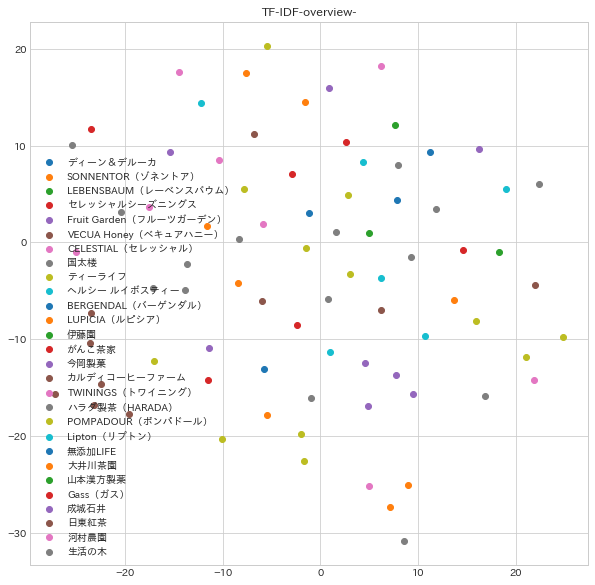

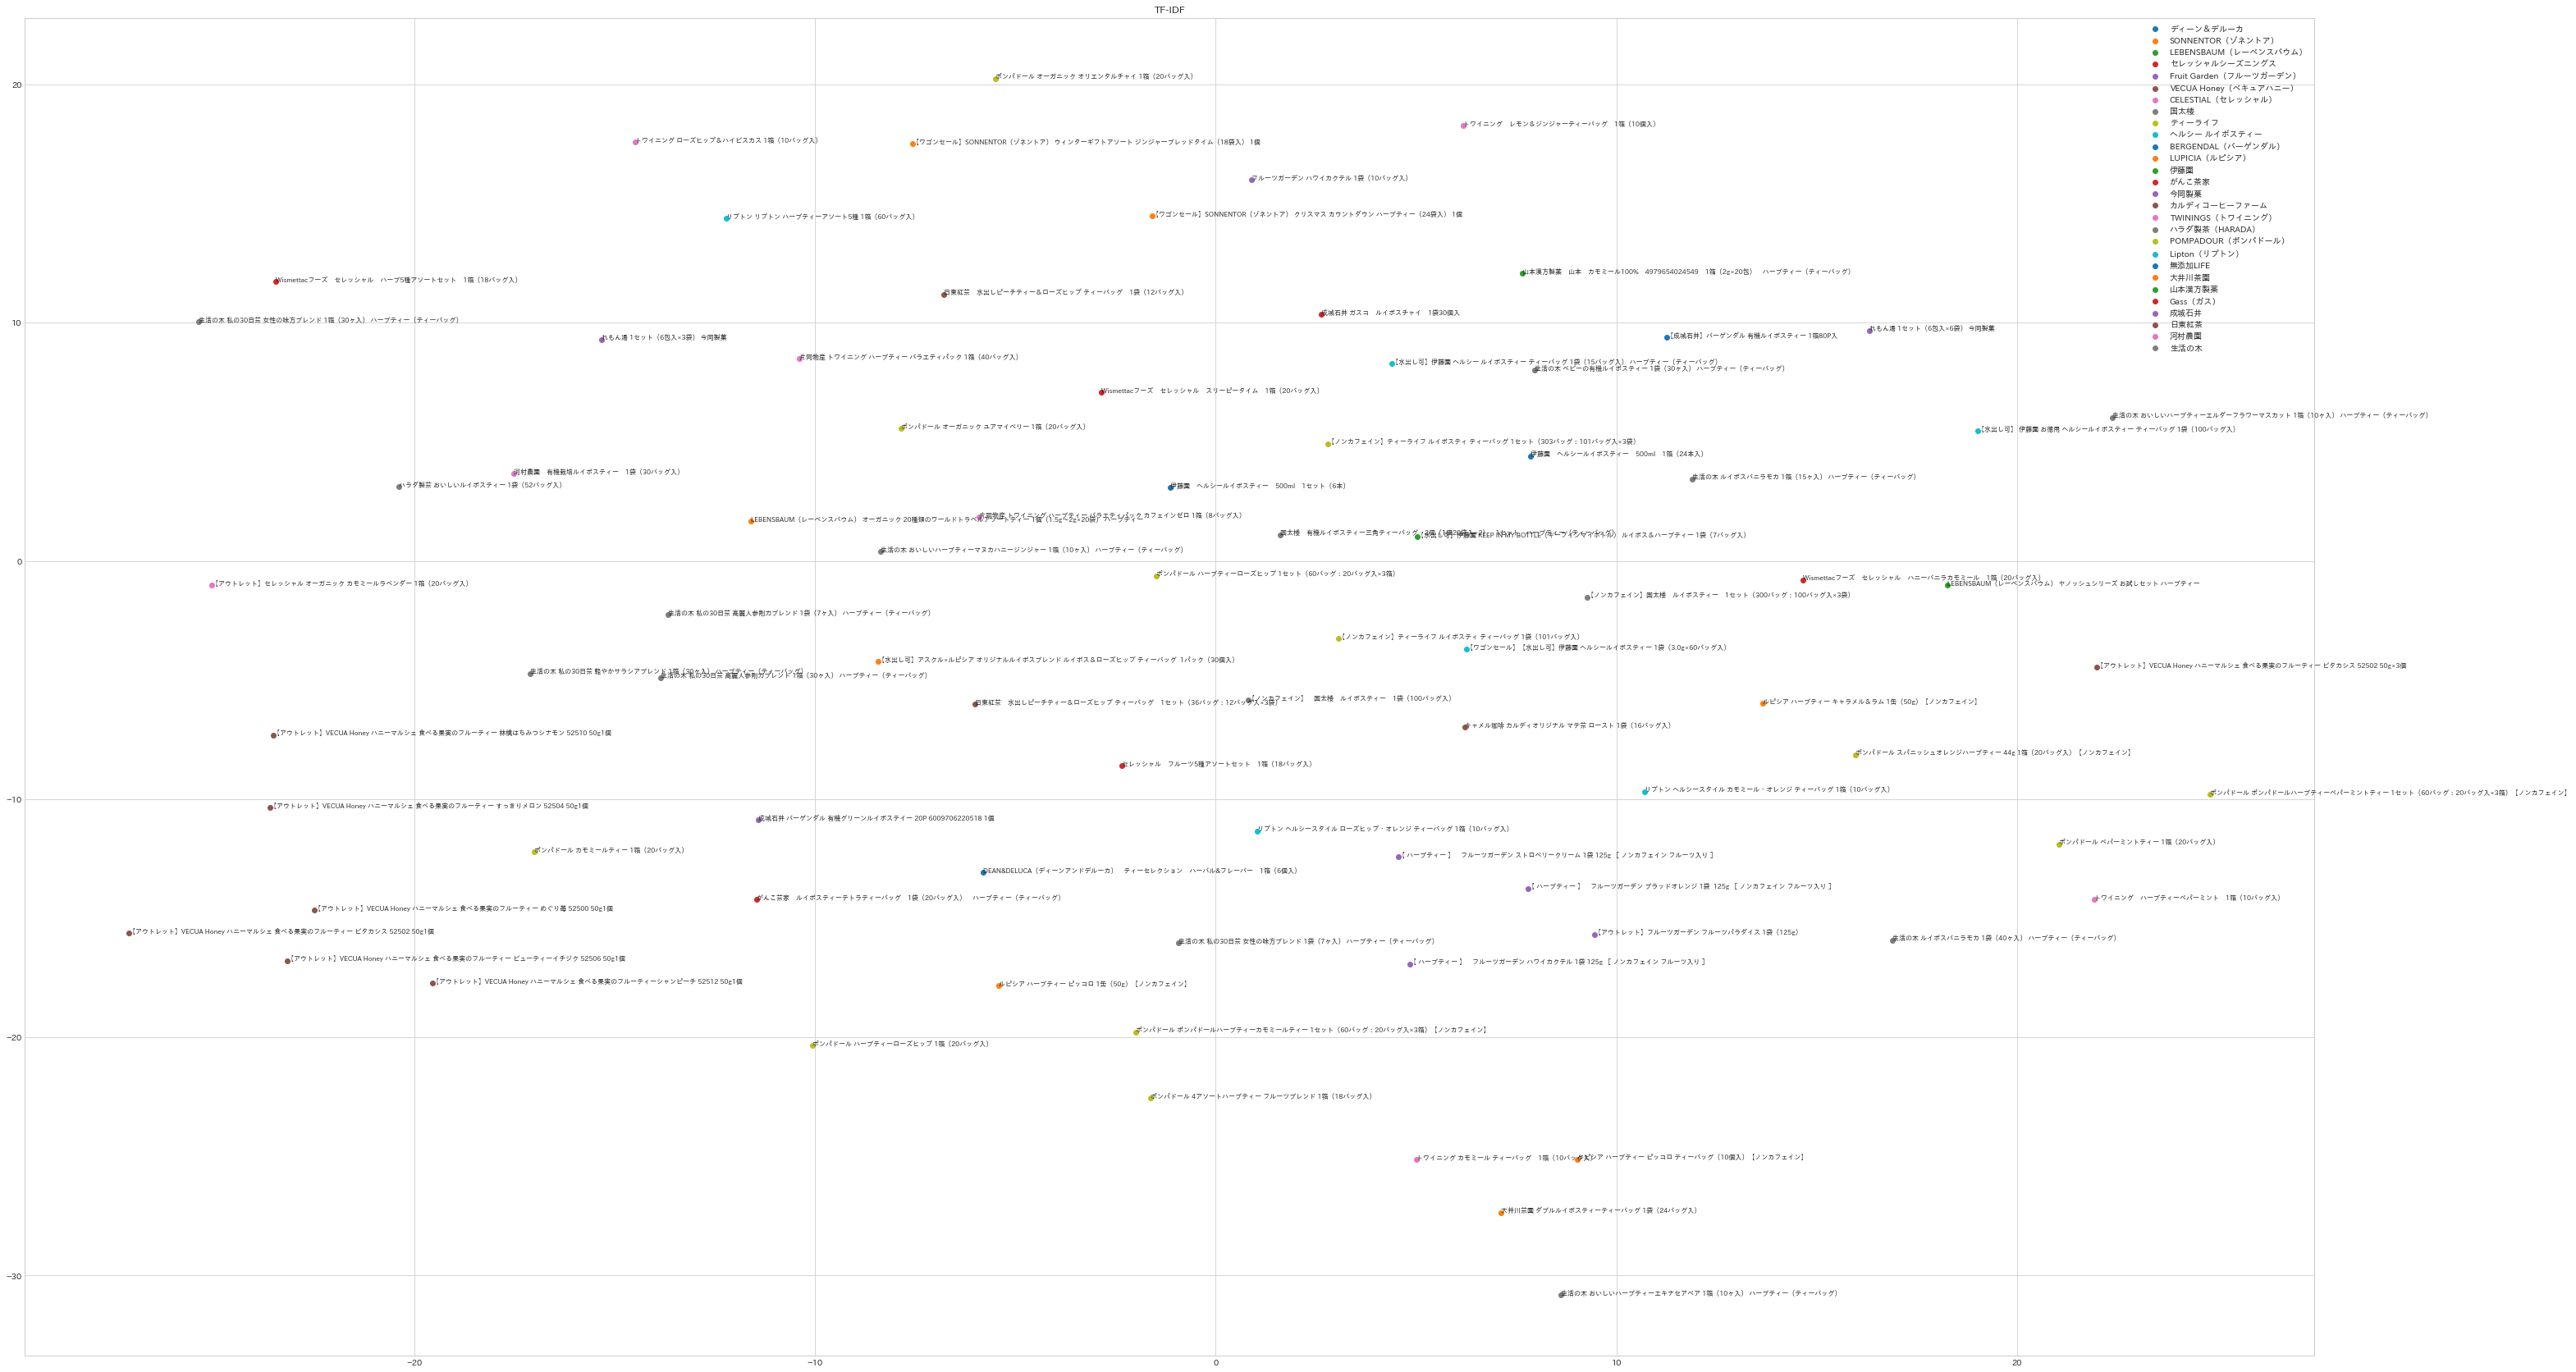

In [7]:
##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

plt.legend()
plt.title("TF-IDF-overview-")
plt.show()

#B: Detail
fig_detail = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne["product_name"].values):
    plt.annotate(txt, (df_tsne["x"].values[i], df_tsne["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("TF-IDF")
plt.show()

In [64]:
##LDA analytics (after filtering TF-IDF)

import gensim
from gensim import corpora, models

#Dictionary is the set of "word ID, word, frequency" data (can be saved)
dictionary =corpora.Dictionary(text)
corpus = [dictionary.doc2bow(doc) for doc in text_combined]

#Can filter TF-IDF before LDA
#TF = Term Frequency -> frequency of each word (the bigger, the more important)
#IDF = Inverse document frequency -> filtering too high frequent words like "a, the, there etc.."
#Below is the class for TF-IDF analytics
#tfidf = gensim.models.TfidfModel(corpus)
#corpus_tfidf = tfidf[corpus]

#Number of topics
zk = 10
#Learning model (can be saved)
lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=zk, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000)

for i in range(zk):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)[0:80]+'...'))

tpc_0: 0.042*"香り" + 0.042*"お湯" + 0.042*"美味しい" + 0.042*"イニング" + 0.042*"トワ" + 0.026*"いい" ...
tpc_1: 0.053*"飲ん" + 0.044*"すぎ" + 0.036*"入れ" + 0.027*"" + 0.027*"お茶" + 0.027*"はちみつ" + 0....
tpc_2: 0.045*"香り" + 0.036*"思い" + 0.027*"良い" + 0.027*"強い" + 0.023*"ローズ" + 0.023*"ヒップ" + ...
tpc_3: 0.040*"飲む" + 0.031*"ティー" + 0.027*"思い" + 0.027*"ハーブ" + 0.027*"毎年" + 0.027*"飲み" + ...
tpc_4: 0.075*"購入" + 0.072*"飲ん" + 0.028*"味" + 0.028*"飲み" + 0.024*"飲む" + 0.024*"生姜" + 0.0...
tpc_5: 0.048*"飲み" + 0.037*"飲ん" + 0.034*"やすい" + 0.032*"味" + 0.024*"" + 0.023*"購入" + 0.02...
tpc_6: 0.079*"ティー" + 0.070*"おしゃれ" + 0.070*"過ごせ" + 0.070*"タイム" + 0.042*"美味しい" + 0.037*"い...
tpc_7: 0.036*"香り" + 0.034*"思い" + 0.033*"飲み" + 0.025*"美味しい" + 0.024*"飲ん" + 0.024*"美味しく" ...
tpc_8: 0.037*"" + 0.029*"いい" + 0.027*"ティー" + 0.027*"良い" + 0.023*"あり" + 0.021*"パック" + 0....
tpc_9: 0.073*"購入" + 0.044*"飲み" + 0.044*"やすい" + 0.044*"ルイボスティー" + 0.030*"飲む" + 0.030*"味"...


product_name    Prob_1    Prob_2  \
0   DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　...  0.020000  0.020005   
1   LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...  0.003125  0.003126   
2        LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー  0.008335  0.008335   
3             Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）  0.003030  0.003031   
4          Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）  0.002857  0.002858   
5         Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）  0.025000  0.025002   
6   【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...  0.005000  0.005001   
7   【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...  0.004000  0.004001   
8   【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...  0.009092  0.009091   
9   【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...  0.005883  0.005883   
10  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 ...  0.020000  0.020000   
11  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス...  0.005883  0.005883   
12  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス...  0.909992  0.010001   
13  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティ...  0.020000  0.020000   
14  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみ...  0.004546  0.004546   
15  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ...  0.399124  0.009092   
16        【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）  0.020010  0.020005   
17                【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）  0.005556  0.005556   
18                  【ノンカフェイン】　国太楼　ルイボスティー　1袋（100バッグ入）  0.002273  0.002273   
19  【ノンカフェイン】ティーライフ ルイボスティ ティーバッグ 1セット（303バッグ：101バ...  0.003226  0.003226   
20          【ノンカフェイン】ティーライフ ルイボスティ ティーバッグ 1袋（101バッグ入）  0.001539  0.001539   
21       【ノンカフェイン】国太楼　ルイボスティー　1セット（300バッグ：100バッグ入×3袋）  0.006667  0.939993   
22  【ワゴンセール】SONNENTOR（ゾネントア） ウィンターギフトアソート ジンジャーブレッ...  0.004000  0.004000   
23  【ワゴンセール】SONNENTOR（ゾネントア） クリスマス カウントダウン ハーブティー（...  0.012500  0.012501   
24      【ワゴンセール】【水出し可】伊藤園 ヘルシールイボスティー 1袋（3.0g×60バッグ入）  0.001064  0.001064   
25                      【成城石井】バーゲンダル 有機ルイボスティー 1箱80P入  0.003334  0.003334   
26      【水出し可】 伊藤園 お徳用 ヘルシールイボスティー ティーバッグ 1袋（100バッグ入）  0.003704  0.003704   
27  【水出し可】アスクル×ルピシア オリジナルルイボスブレンド ルイボス＆ローズヒップ ティーバ...  0.006667  0.006668   
28  【水出し可】伊藤園 KEEP IN MY BOTTLE（キープインマイボトル） ルイボス＆ハ...  0.005884  0.005883   
29  【水出し可】伊藤園 ヘルシー ルイボスティー ティーバッグ 1袋（15バッグ入） ハーブティ...  0.004546  0.004546   

      Prob_3    Prob_4    Prob_5    Prob_6    Prob_7    Prob_8    Prob_9  \
0   0.020002  0.020001  0.819985  0.020001  0.020000  0.020002  0.020001   
1   0.003126  0.003126  0.003125  0.003126  0.003126  0.003126  0.971869   
2   0.008335  0.008334  0.008334  0.008335  0.008334  0.924988  0.008336   
3   0.003031  0.003031  0.003031  0.003031  0.003031  0.972723  0.003031   
4   0.002858  0.002858  0.002858  0.002858  0.002858  0.974281  0.002858   
5   0.025009  0.025000  0.025008  0.025013  0.774940  0.025011  0.025009   
6   0.666321  0.005000  0.005001  0.293674  0.005000  0.005001  0.005001   
7   0.963997  0.004000  0.004000  0.004001  0.004000  0.004001  0.004000   
8   0.918177  0.009091  0.009091  0.009092  0.009091  0.009092  0.009092   
9   0.005883  0.005884  0.005883  0.005883  0.947054  0.005883  0.005883   
10  0.020000  0.020001  0.020000  0.020001  0.819997  0.020000  0.020001   
11  0.005883  0.557589  0.005883  0.005883  0.395347  0.005883  0.005883   
12  0.010001  0.010001  0.010000  0.010001  0.010001  0.010002  0.010000   
13  0.020000  0.020001  0.020000  0.020001  0.819997  0.020000  0.020001   
14  0.004546  0.959087  0.004546  0.004546  0.004546  0.004546  0.004546   
15  0.009093  0.009092  0.009091  0.009092  0.528140  0.009092  0.009092   
16  0.020014  0.020003  0.819930  0.020010  0.020003  0.020019  0.020003   
17  0.424036  0.005556  0.005557  0.005557  0.005556  0.531513  0.005557   
18  0.979541  0.002273  0.002273  0.002273  0.002273  0.002273  0.002273   
19  0.003226  0.003226  0.003226  0.003226  0.003226  0.003226  0.003226   
20  0.001539  0.001539  0.001539  0.562583  0.001539  0.0

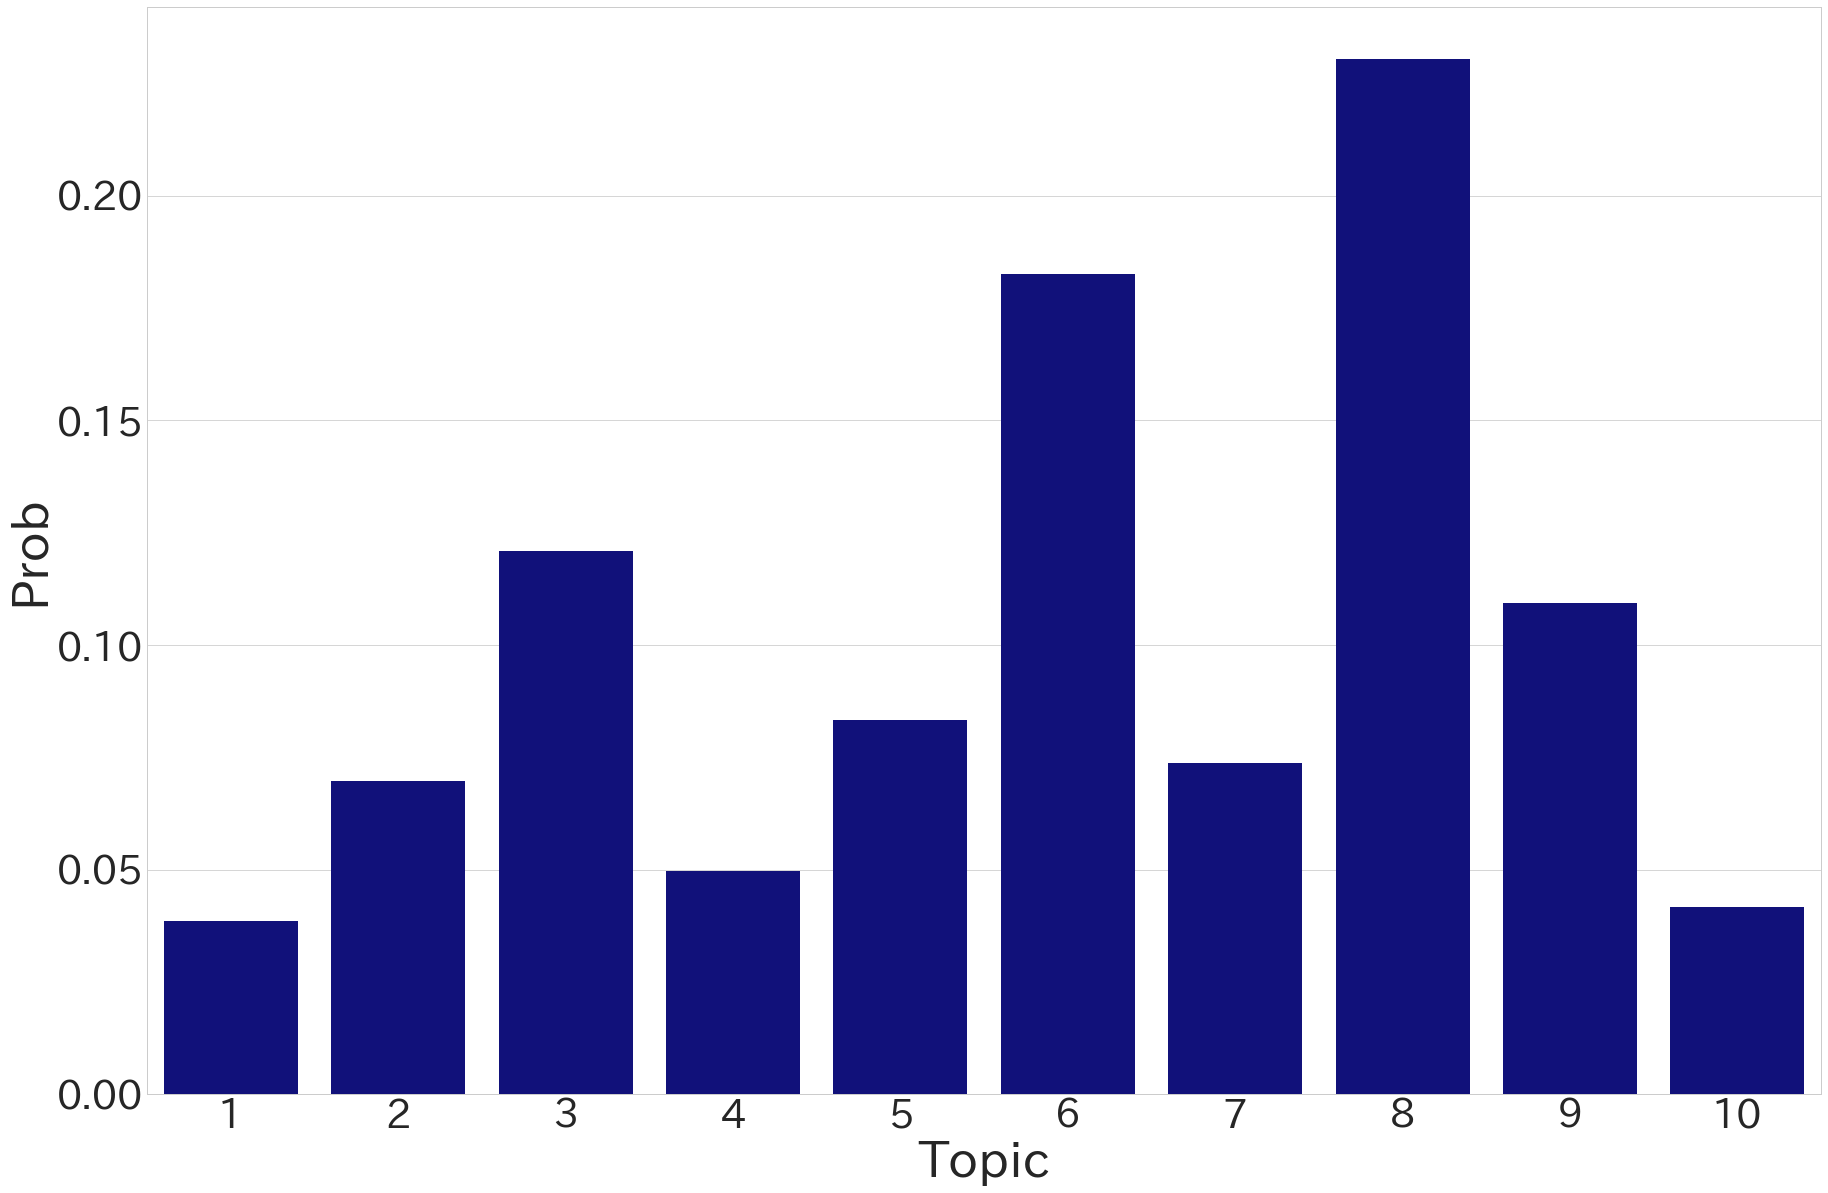

In [65]:
#Make Numpy b/w Products & topics
Prob_products=np.array(lda.get_document_topics(corpus,minimum_probability=0))[:,:,1]

#Put in DataFrame
L=[ z for z in range(1,zk+1)]
col_name=list(map(lambda x: "Prob_"+str(x),L))
df_prob=pd.DataFrame(Prob_products)
df_prob.columns=col_name

#Add product name & most likely belonging topic No.
df_prob["Max"]=df_prob.idxmax(axis=1)
def del_Prob(x):
    return int(x.split("_")[1])
df_prob["Max"]=df_prob["Max"].apply(lambda x : del_Prob(x))
df_prob.insert(0, "product_name", df_new_combined["product_name"])
display(df_prob.head(30))

#Calculate probability of apperance of each topic
df_topic=pd.DataFrame(df_prob.drop(["Max", "product_name"],axis=1).sum()/df_prob.drop(["Max", "product_name"],axis=1).sum().sum())
df_topic.columns=["Prob"]
df_topic["Topic"]=[ z for z in range(1,zk+1)]

#Visualization
plt.figure(figsize = (30,20))
ax= sns.barplot(x="Topic",y="Prob",data=df_topic,color="darkblue")
ax.set_xlabel("Topic",fontsize=50)
ax.set_ylabel("Prob",fontsize=50)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
plt.show()

<Figure size 1512x864 with 0 Axes>

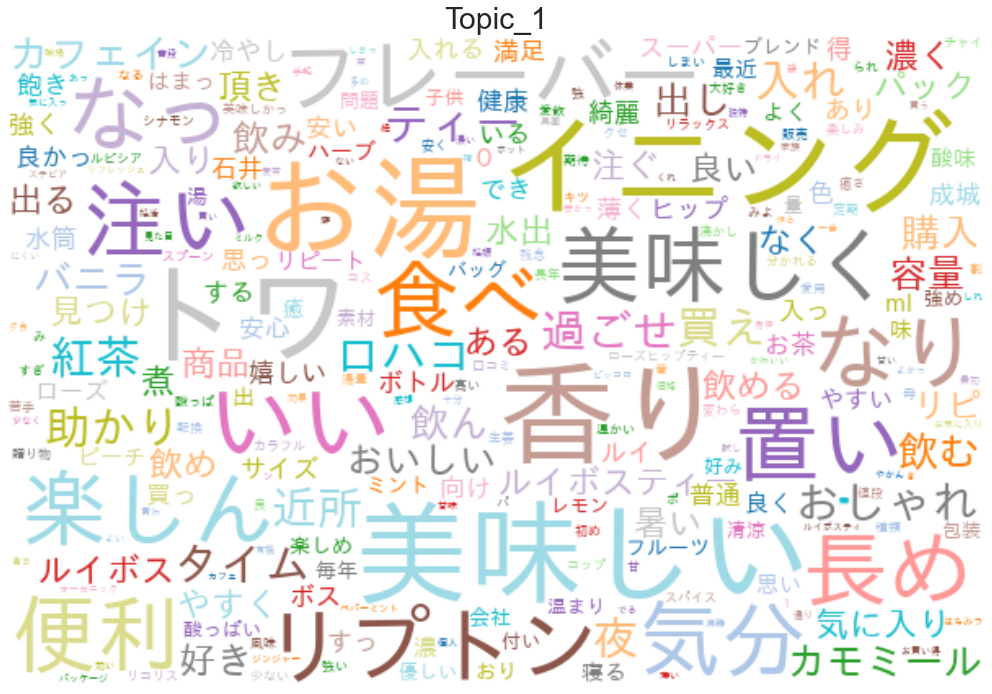

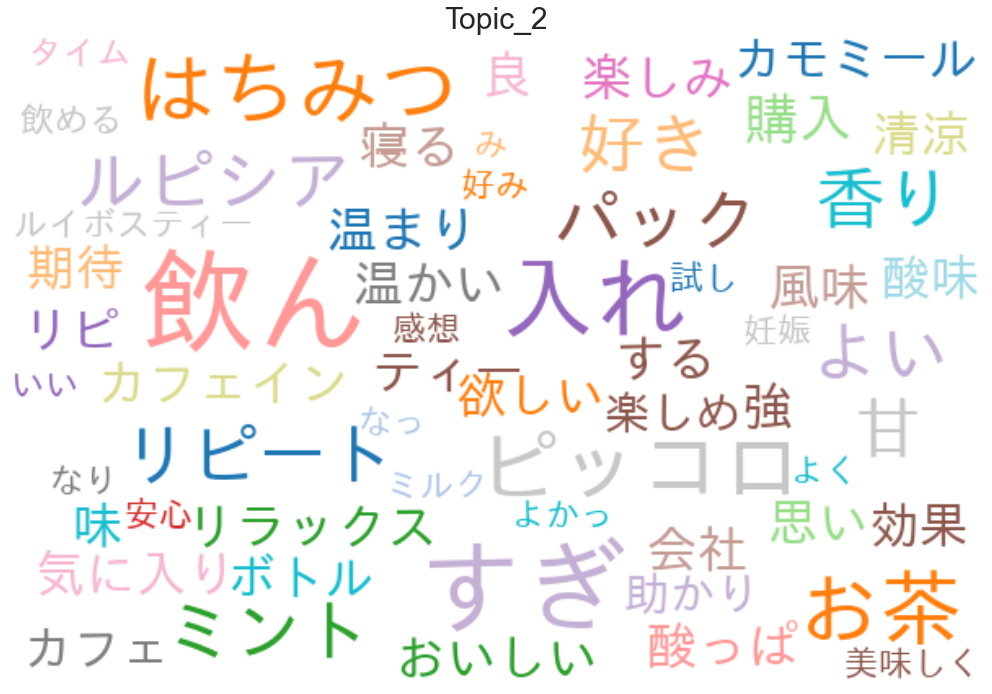

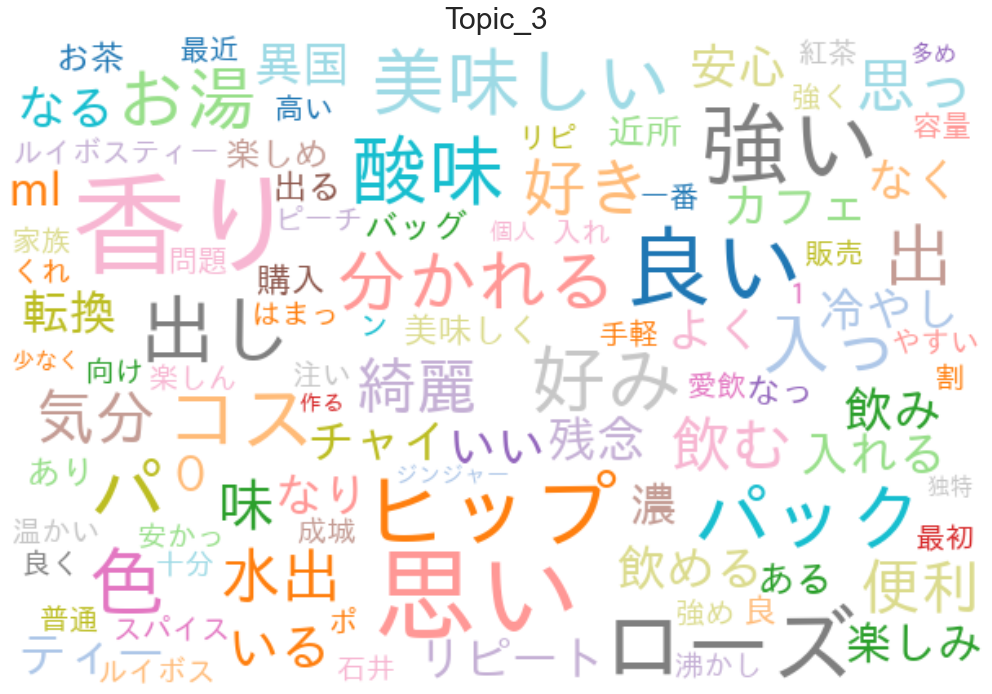

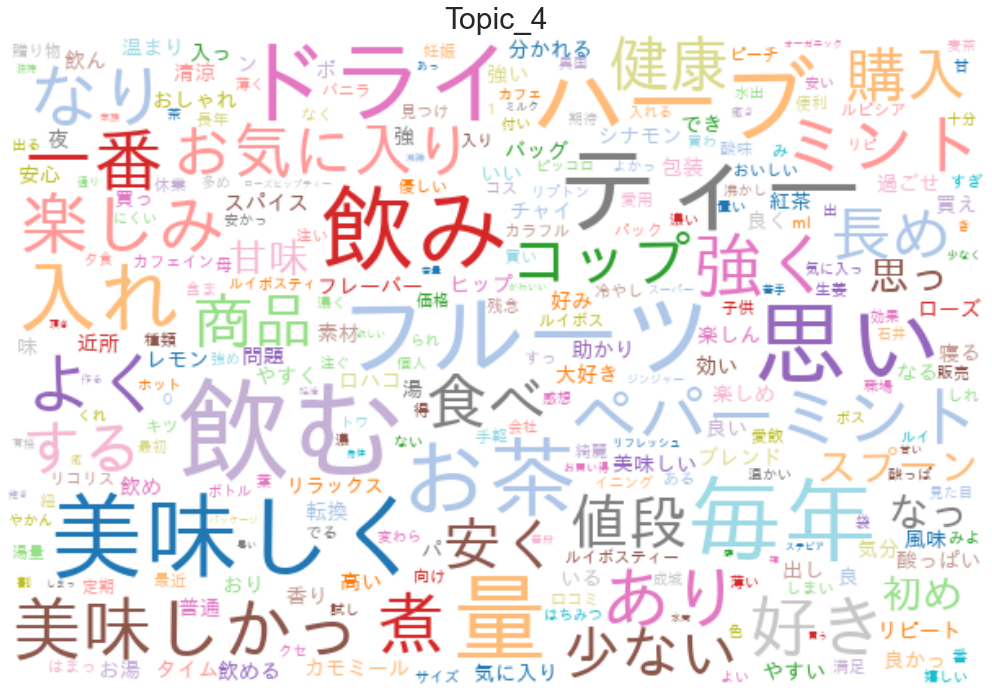

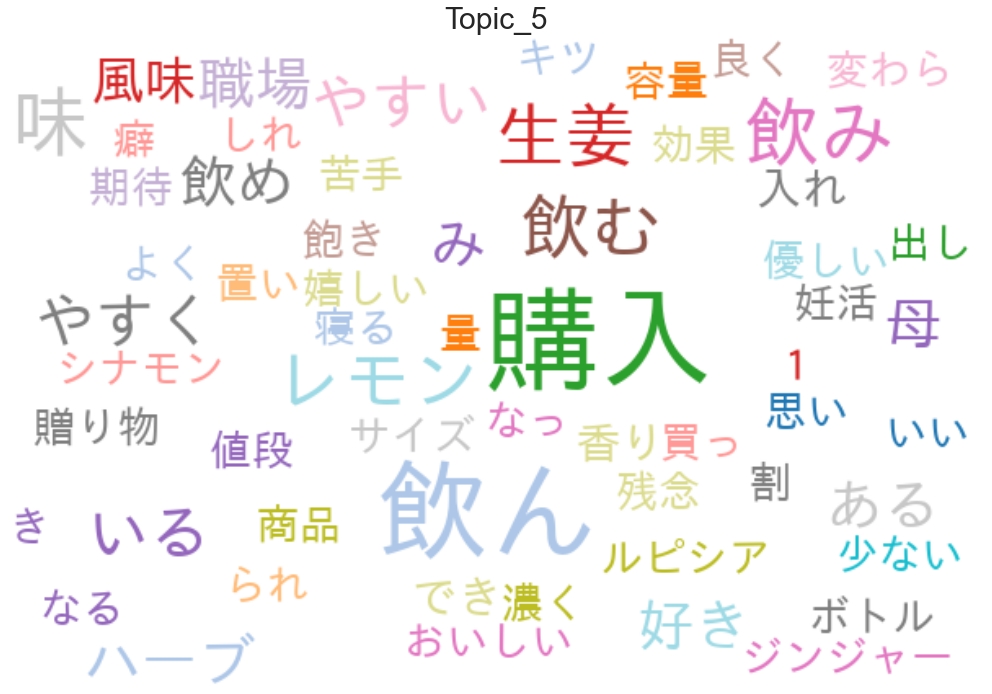

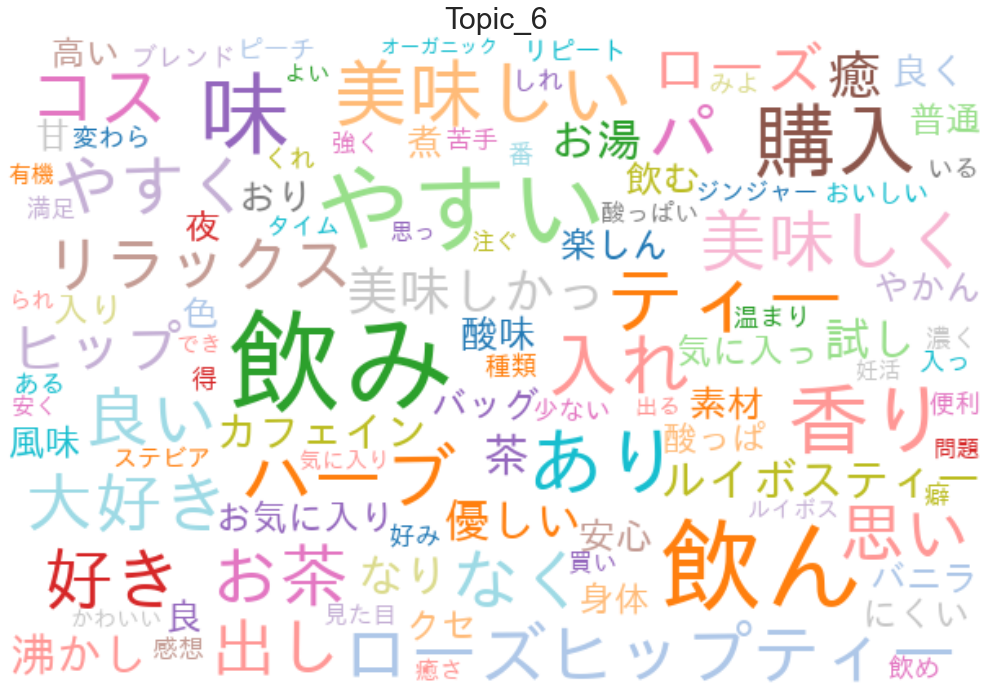

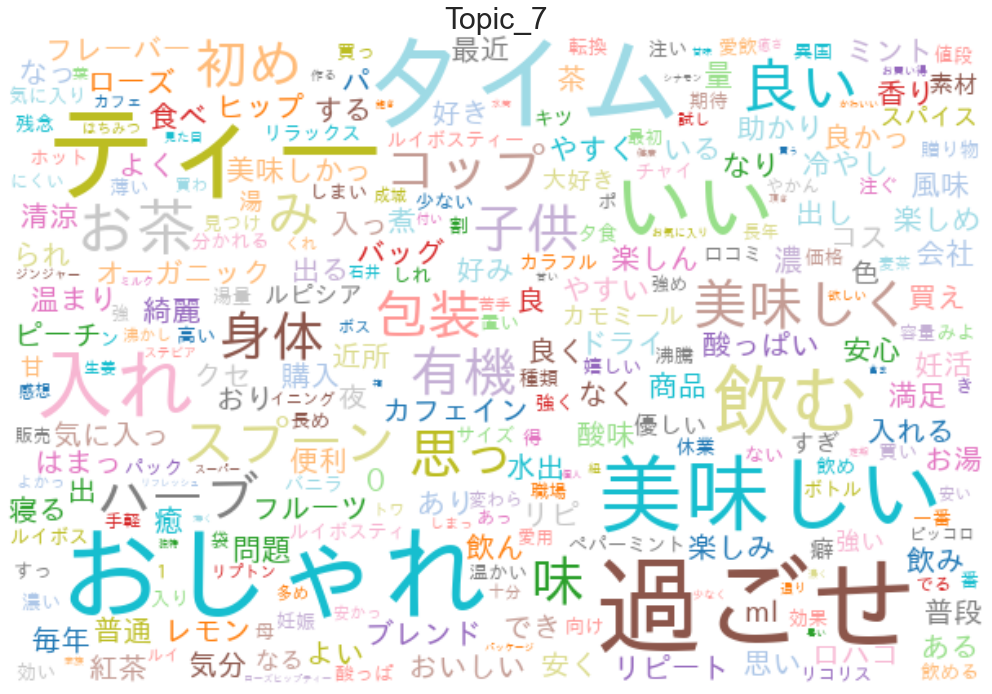

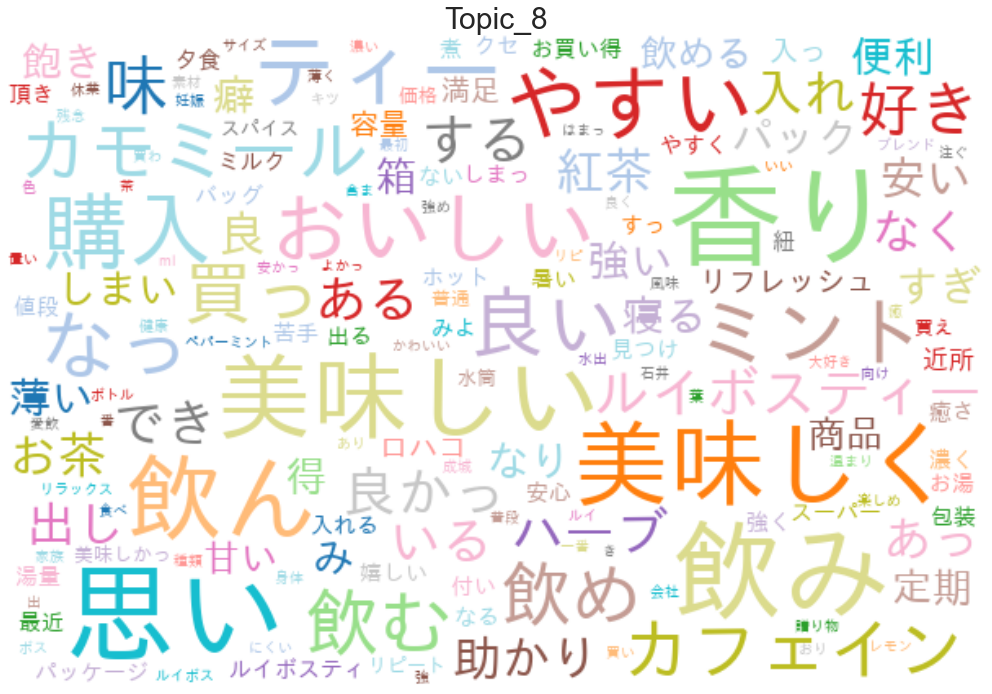

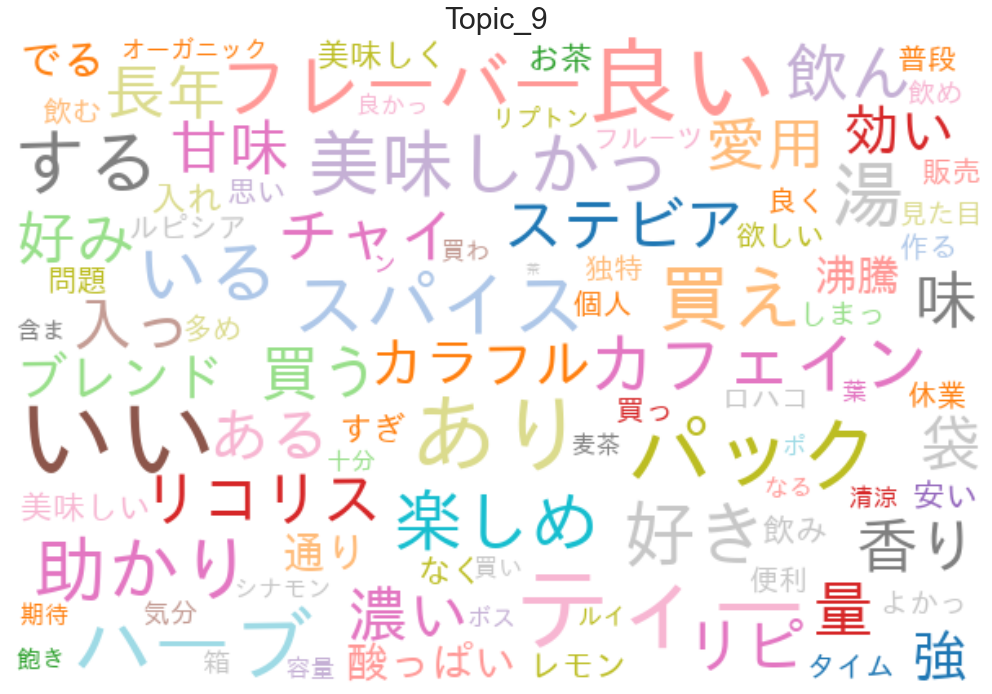

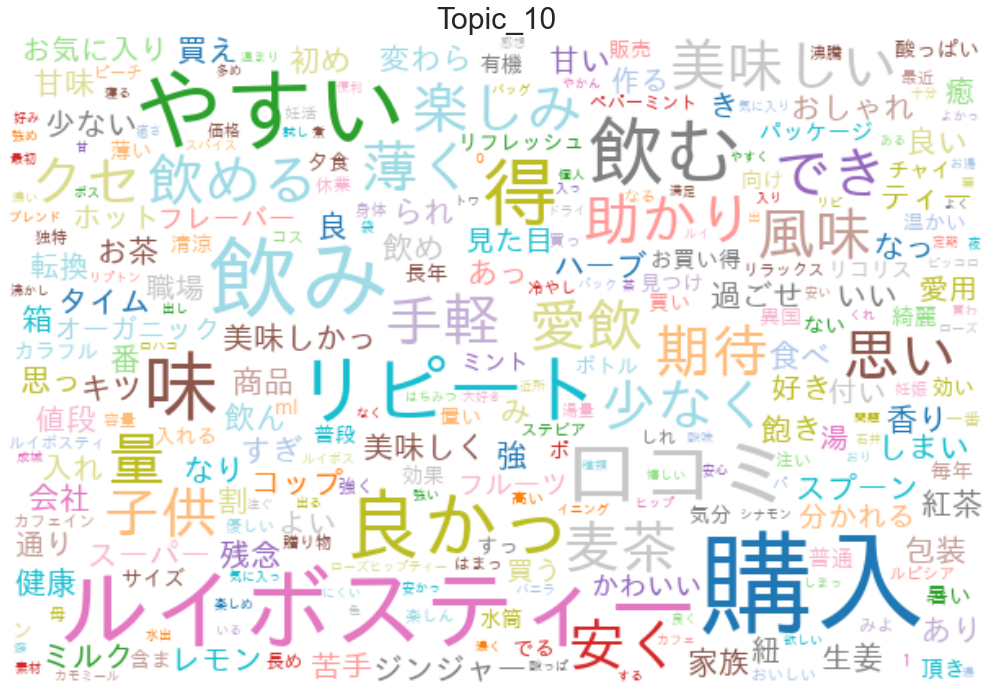

In [68]:
##Visualization of words

topic_word_prob=[]

for z in range(zk):
    word=[]
    prob=[]
    topic = lda.show_topic(z,1000) #No. of words

    for t in topic:
        word.append(t[0])
        prob.append(t[1])
        
    df_lda=pd.DataFrame({"word":word,"prob":prob})
    topic_word_prob.append(df_lda)

fig = plt.figure(figsize=(21, 12))

for z in range(zk):
    topic_text=[]
    for index, row in topic_word_prob[z].iloc[:2000,].iterrows():
        word=row["word"]
        weight=int(row["prob"]*1000)
        for _ in range(weight):
            topic_text.append(word)
            
    words = Counter(topic_text)
    wc_bz = WordCloud(background_color="white",
                      width=600, 
                      height=400, 
                      max_words=3000, 
                      max_font_size=70, 
                      font_path=fpath,
                      prefer_horizontal=1,
                      include_numbers=True,
                      colormap='tab20',
                      regexp=r"[\w']+")
    wc_bz.generate_from_frequencies(words)

    plt.figure(figsize = (21,12))
    sns.set_style("whitegrid")
    plt.title('Topic_{}'.format(z+1), fontsize=30)
    plt.imshow(wc_bz, interpolation='bilinear')
    plt.axis("off")
    
    # topic groups output to png
    output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/lohaco"
    pngname =  f"{today}_{category}_{zk}topics"
    plt.savefig(f'{output_dir}/{pngname}_{z+1}.png')
    plt.show()

In [45]:
##Word2Vec Analysis
from gensim.models import word2vec

sent = text_combined
#Learning word2vec model
model = word2vec.Word2Vec(sent,
                          vector_size=50,  # Demention of vector (depends on the number of unique words)
                          min_count=2,  # Words appearing at least 2 times
                          window=5,  # Width of window
                          epochs=4000,  # Iter numbers of leaning
                          seed=2018 # Fix seed for generating stable random number
                         )

In [46]:
word = "リプトン"
# Output the most similar words & similarity index
results = model.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


0         1         2         3         4         5         6   \
Word        トワ      イニング        含ま        毎年        酸味        一番      酸っぱい   
Sim   0.503478  0.489715  0.419873  0.326249  0.322715  0.315272  0.295669   

            7         8         9         10        11        12      13  \
Word     ジンジャー       ピーチ        綺麗        清涼       楽しみ       温かい     レモン   
Sim   0.295229  0.292815  0.283533  0.274624  0.273924  0.257834  0.2556   

            14        15        16        17        18        19  
Word        最近       はまっ        残念       温まり        向け        強い  
Sim   0.254127  0.248342  0.246455  0.243701  0.224303  0.221184

In [50]:
## Plus/Minus words and show the similarities
results = model.wv.most_similar(positive=[u"ルイボス",u"美味しい"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2         3         4         5         6   \
Word        子供   ルイボスティー        飲み       少なく         母       バニラ        健康   
Sim   0.491984  0.428961  0.363454  0.339553  0.327391  0.296987  0.286571   

            7         8         9         10        11       12        13  \
Word        なる         １       酸っぱ        入っ        いる   ルイボスティ       口コミ   
Sim   0.282587  0.280377  0.276089  0.261365  0.254071  0.25315  0.239916   

            14        15        16       17        18        19  
Word        でき        思い        水筒       種類        注ぐ        作る  
Sim   0.239635  0.230769  0.228517  0.21024  0.207163  0.206145

In [54]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.product_name[i])
    feature_vec = np.zeros(50)
    num_words = 0
    for word in product:
        try:
            feature_vec += model.wv[word]
            num_words += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec = feature_vec / num_words  # Split sum of all the words vector
    product_vec[i] = feature_vec

##t-SNE for Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_word2vec = tsne.fit_transform(product_vec)

DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　1箱（6個入）
LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートティー 1個（1.5g～2g×20袋） ハーブティー
LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー
Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）
【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイン フルーツ入り ］
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメロン 52504 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 52500 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g×3個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティーイチジク 52506 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみつシナモン 52510 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ 52512 50g1個
【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）
【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）
【ノンカフェイン】　国太楼　ルイボスティー　1袋（10

x          y                                       product_name  \
0  15.421871 -32.642307  DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　...   
1  13.768413  24.291910  LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...   
2  18.572802   5.938023       LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー   
3  10.622675 -29.100092            Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）   
4  13.246469   9.407538         Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）   
5   4.146376  10.501554        Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）   
6  10.620839 -17.488949  【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...   
7   4.419537 -22.490021  【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...   
8  28.651991 -12.408365  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
9 -25.450825 -30.221359  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...   

                    brand  
0               ディーン＆デルーカ  
1        SONNENTOR（ゾネントア）  
2    LEBENSBAUM（レーベンスバウム）  
3           セレッシャルシーズニングス  
4           セレッシャルシーズニングス  
5           セレッシャルシーズニングス  
6  Fruit Garden（フルーツガーデン）  
7  Fruit Garden（フルーツガーデン）  
8  Fruit Garden（フルーツガーデン）  
9    VECUA Honey（ベキュアハニー）

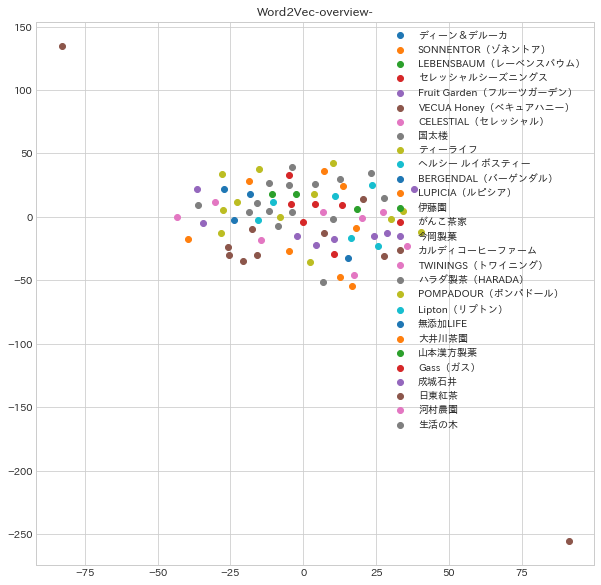

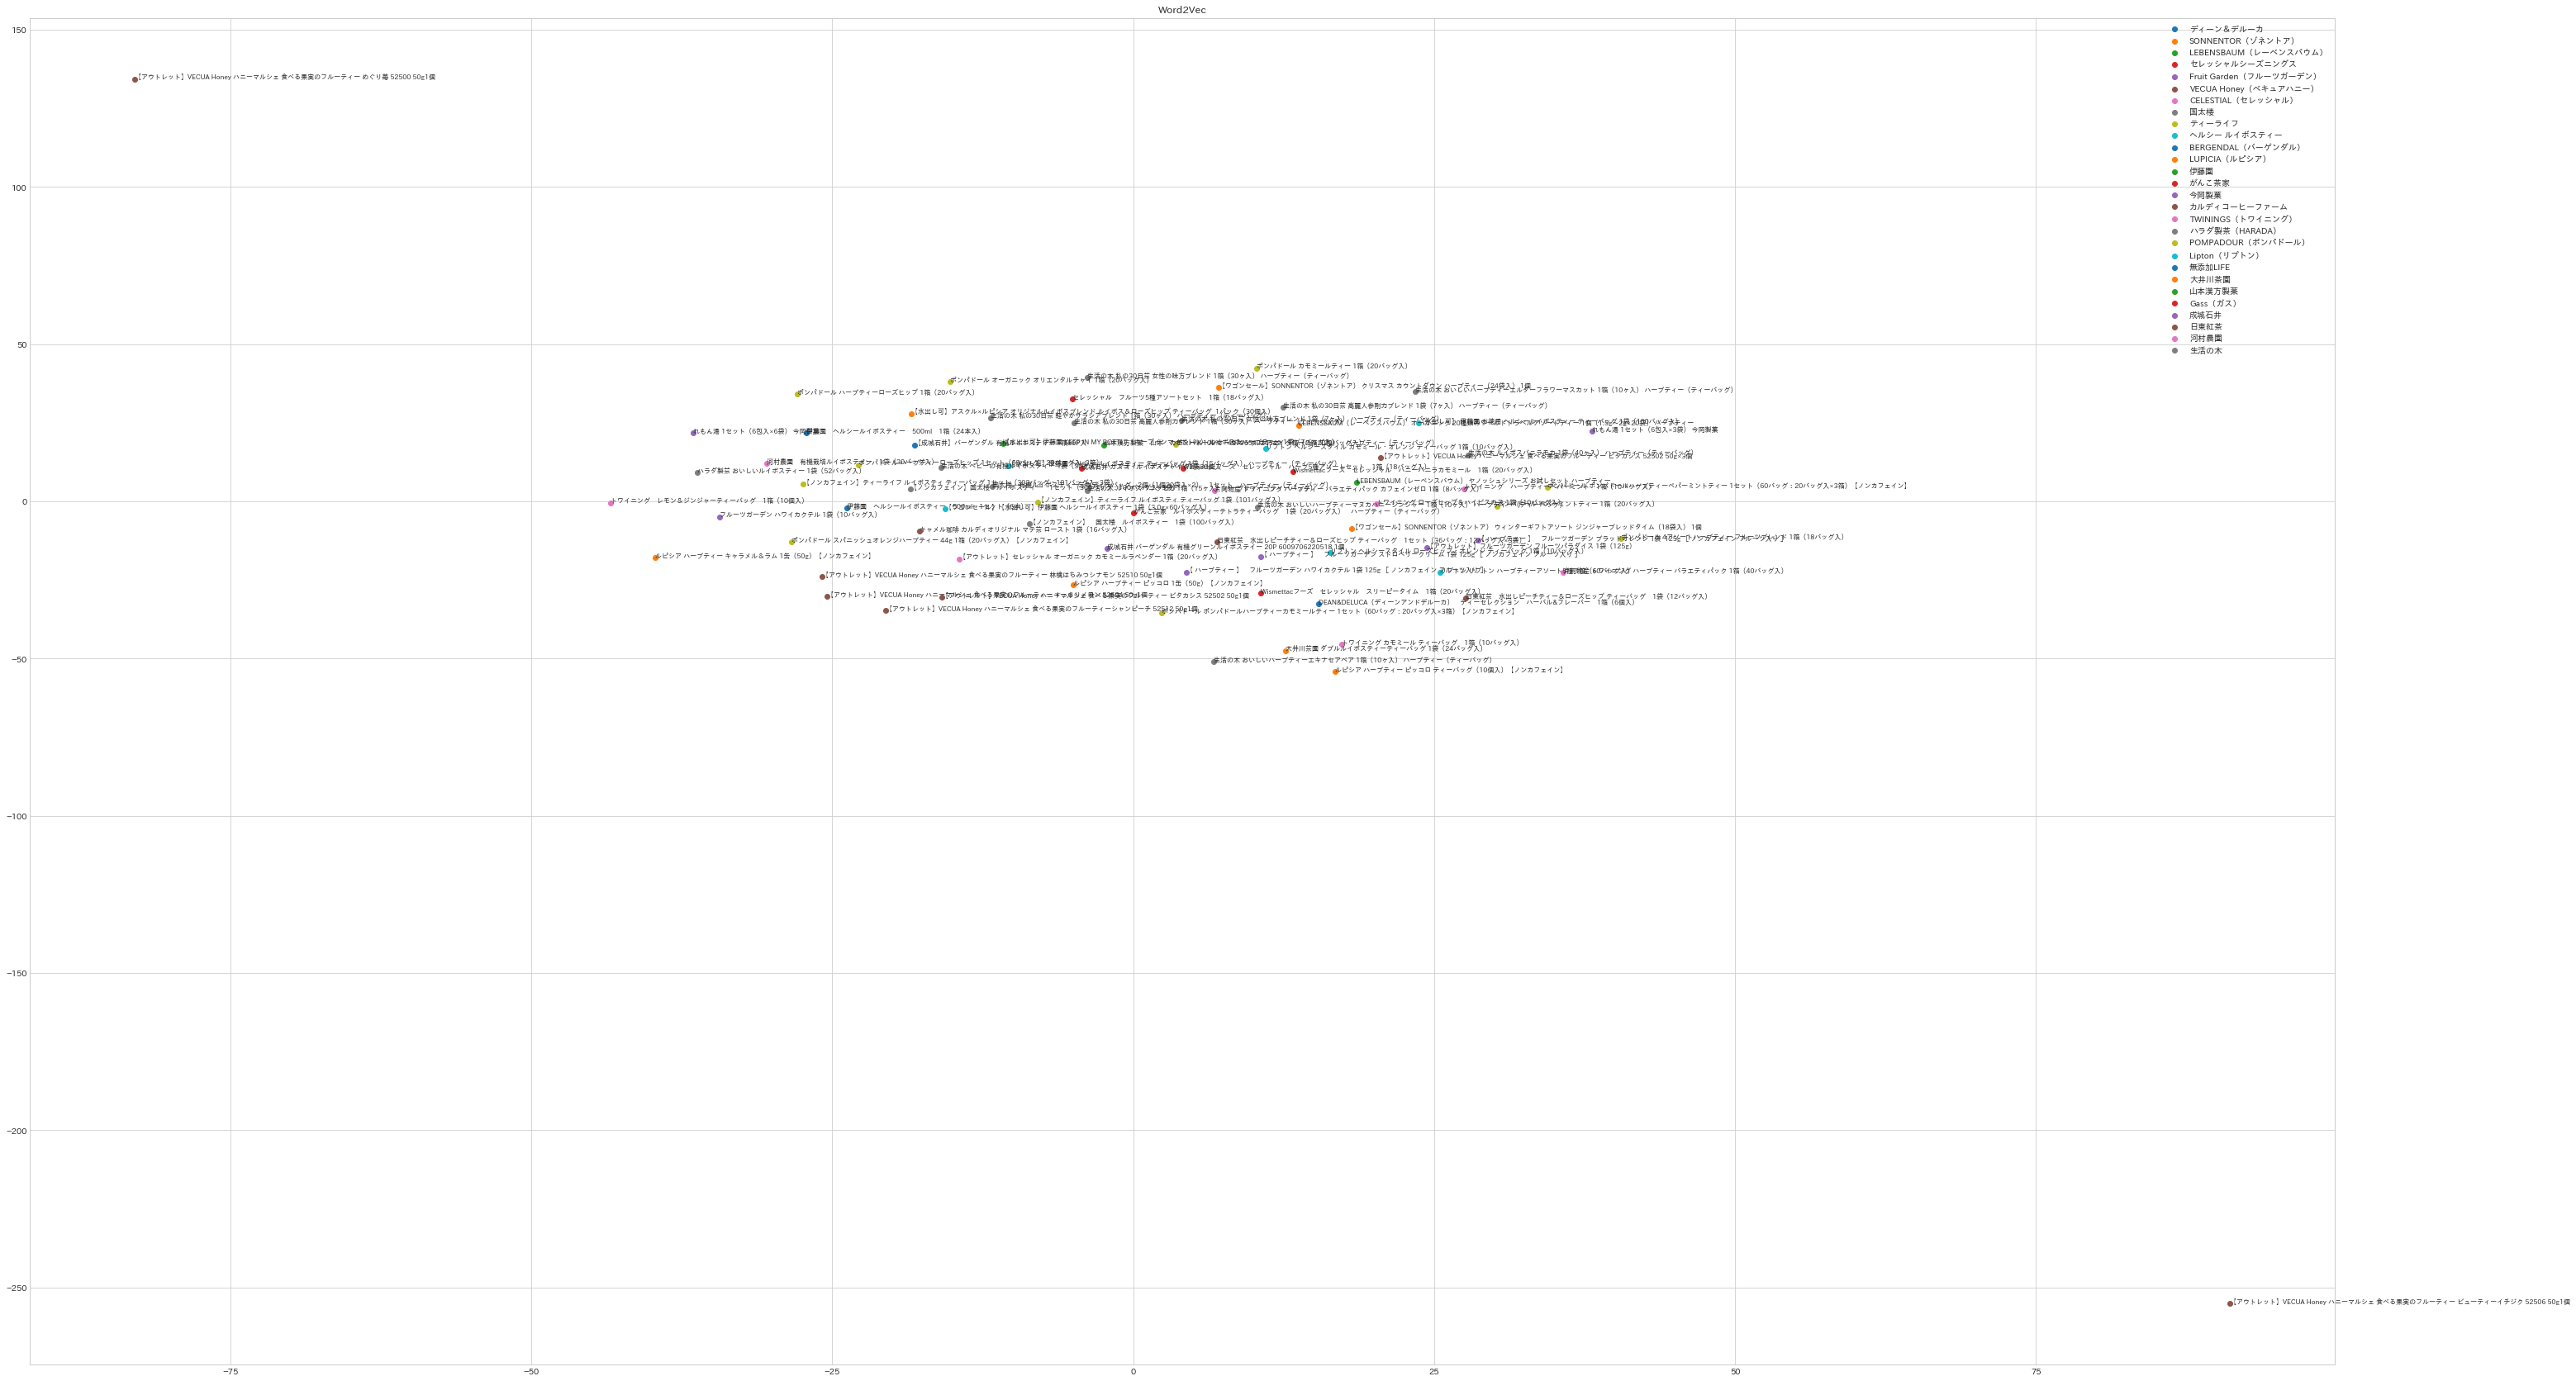

In [56]:
#Put in DataFrame
df_tsne_word2vec = pd.DataFrame(tsne_word2vec[:, 0],columns = ["x"])
df_tsne_word2vec["y"] = pd.DataFrame(tsne_word2vec[:, 1])
df_tsne_word2vec["product_name"] = df_new_combined.product_name  
df_tsne_word2vec["brand"] = df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_word2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_word2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Word2Vec-overview-")

#B: Detail
fig_detail_word2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_word2vec["product_name"].values):
    plt.annotate(txt, (df_tsne_word2vec["x"].values[i], df_tsne_word2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Word2Vec")

plt.show()

In [47]:
##Doc2Vec analysis

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora, models

trainings_combined = [TaggedDocument(words=data, tags=[name]) for (name, data) in zip(df_new_combined["product_name"], text_combined)]

# Learning model
model_doc_combined = models.Doc2Vec(
    documents=trainings_combined,
    vector_size=50,
    min_count=2,
    epochs=4000
)

In [58]:
word = "リプトン"
# Output the most similar words & similarity index
results = model_doc_combined.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


0         1        2         3        4         5         6   \
Word        トワ       温かい     イニング        一番     気に入っ        綺麗        購入   
Sim   0.535167  0.441997  0.42409  0.359616  0.35638  0.355789  0.332568   

           7         8         9         10        11        12        13  \
Word       思い       安かっ        癒さ        毎年        異国        効い      美味しく   
Sim   0.31348  0.302193  0.300955  0.299515  0.297638  0.291877  0.284169   

           14        15       16        17        18        19  
Word        母        濃く        ０      かわいい        向け        暑い  
Sim   0.28322  0.278115  0.27741  0.259111  0.250586  0.249902

In [59]:
## Plus/Minus words and show the similarities
results = model_doc_combined.wv.most_similar(positive=[u"リプトン",u"安い"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2         3         4         5         6   \
Word        香り        トワ        コス        癒さ        毎年      気に入っ        綺麗   
Sim   0.372038  0.358927  0.339417  0.338398  0.334616  0.324355  0.319897   

            7         8         9         10        11        12        13  \
Word        思い        定期        安心        購入        向け       はまっ        飲む   
Sim   0.317904  0.307789  0.302372  0.288592  0.288399  0.281103  0.277634   

            14       15        16        17       18        19  
Word      イニング    パッケージ        でる        感想       お茶         母  
Sim   0.275786  0.27345  0.260004  0.258803  0.25166  0.251638

In [61]:
## Find similar items(documents)
results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

<ipython-input-61-b771ea8573ae>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")


0                               1  \
Word  ポンパドール カモミールティー 1箱（20バッグ入）  伊藤園　ヘルシールイボスティー　500ml　1箱（24本入）   
Sim                      0.54276                        0.501323   

                                              2  \
Word  ポンパドール ハーブティーローズヒップ 1セット（60バッグ：20バッグ入×3箱）   
Sim                                    0.492985   

                                                      3  \
Word  山本漢方製薬　山本　カモミール100%　4979654024549　1箱（2g×20包）　ハ...   
Sim                                             0.47014   

                                                  4  \
Word  生活の木 私の30日茶 女性の味方ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.45922   

                                                      5  \
Word  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
Sim                                             0.45398   

                                          6  \
Word  ルピシア ハーブティー キャラメル＆ラム 1缶（50g）【ノンカフェイン】   
Sim                                 0.45277   

                                                   7  \
Word  生活の木 私の30日茶 高麗人参剛力ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.448062   

                                           8  \
Word  生活の木 ルイボスバニラモカ 1袋（40ヶ入） ハーブティー（ティーバッグ）   
Sim                                 0.440716   

                                                      9  
Word  ポンパドール ポンパドールハーブティーカモミールティー 1セット（60バッグ：20バッグ入×...  
Sim                                            0.436387

In [48]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec_doc = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.product_name[i])
    feature_vec_doc = np.zeros(50)
    num_words_doc = 0
    for word in product:
        try:
            feature_vec_doc += model_doc_combined.wv[word]
            num_words_doc += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec_doc = feature_vec_doc / num_words_doc  # Split sum of all the words vector
    product_vec_doc[i] = feature_vec_doc

##t-SNE for Doc2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_doc2vec = tsne.fit_transform(product_vec_doc)

DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　1箱（6個入）
LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートティー 1個（1.5g～2g×20袋） ハーブティー
LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー
Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）
【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイン フルーツ入り ］
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメロン 52504 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 52500 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g×3個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティーイチジク 52506 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみつシナモン 52510 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ 52512 50g1個
【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）
【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）
【ノンカフェイン】　国太楼　ルイボスティー　1袋（10

x          y                                       product_name  \
0 -45.109653  79.046638  DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　...   
1  12.106108   1.592252  LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...   
2  17.036133  11.622809       LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー   
3  24.627947  22.885389            Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）   
4   2.782181  10.985058         Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）   
5  -8.521563 -69.922462        Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）   
6 -37.420597   3.177659  【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...   
7  87.071495  38.387630  【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...   
8 -68.426849  27.638330  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
9  51.686825 -58.242813  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...   

                    brand  
0               ディーン＆デルーカ  
1        SONNENTOR（ゾネントア）  
2    LEBENSBAUM（レーベンスバウム）  
3           セレッシャルシーズニングス  
4           セレッシャルシーズニングス  
5           セレッシャルシーズニングス  
6  Fruit Garden（フルーツガーデン）  
7  Fruit Garden（フルーツガーデン）  
8  Fruit Garden（フルーツガーデン）  
9    VECUA Honey（ベキュアハニー）

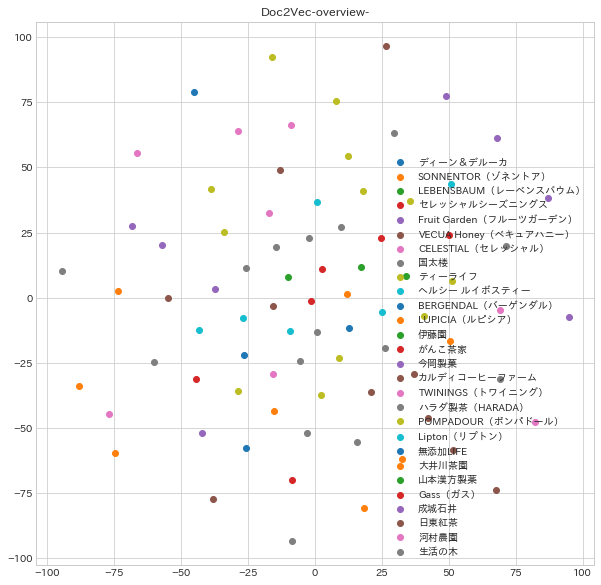

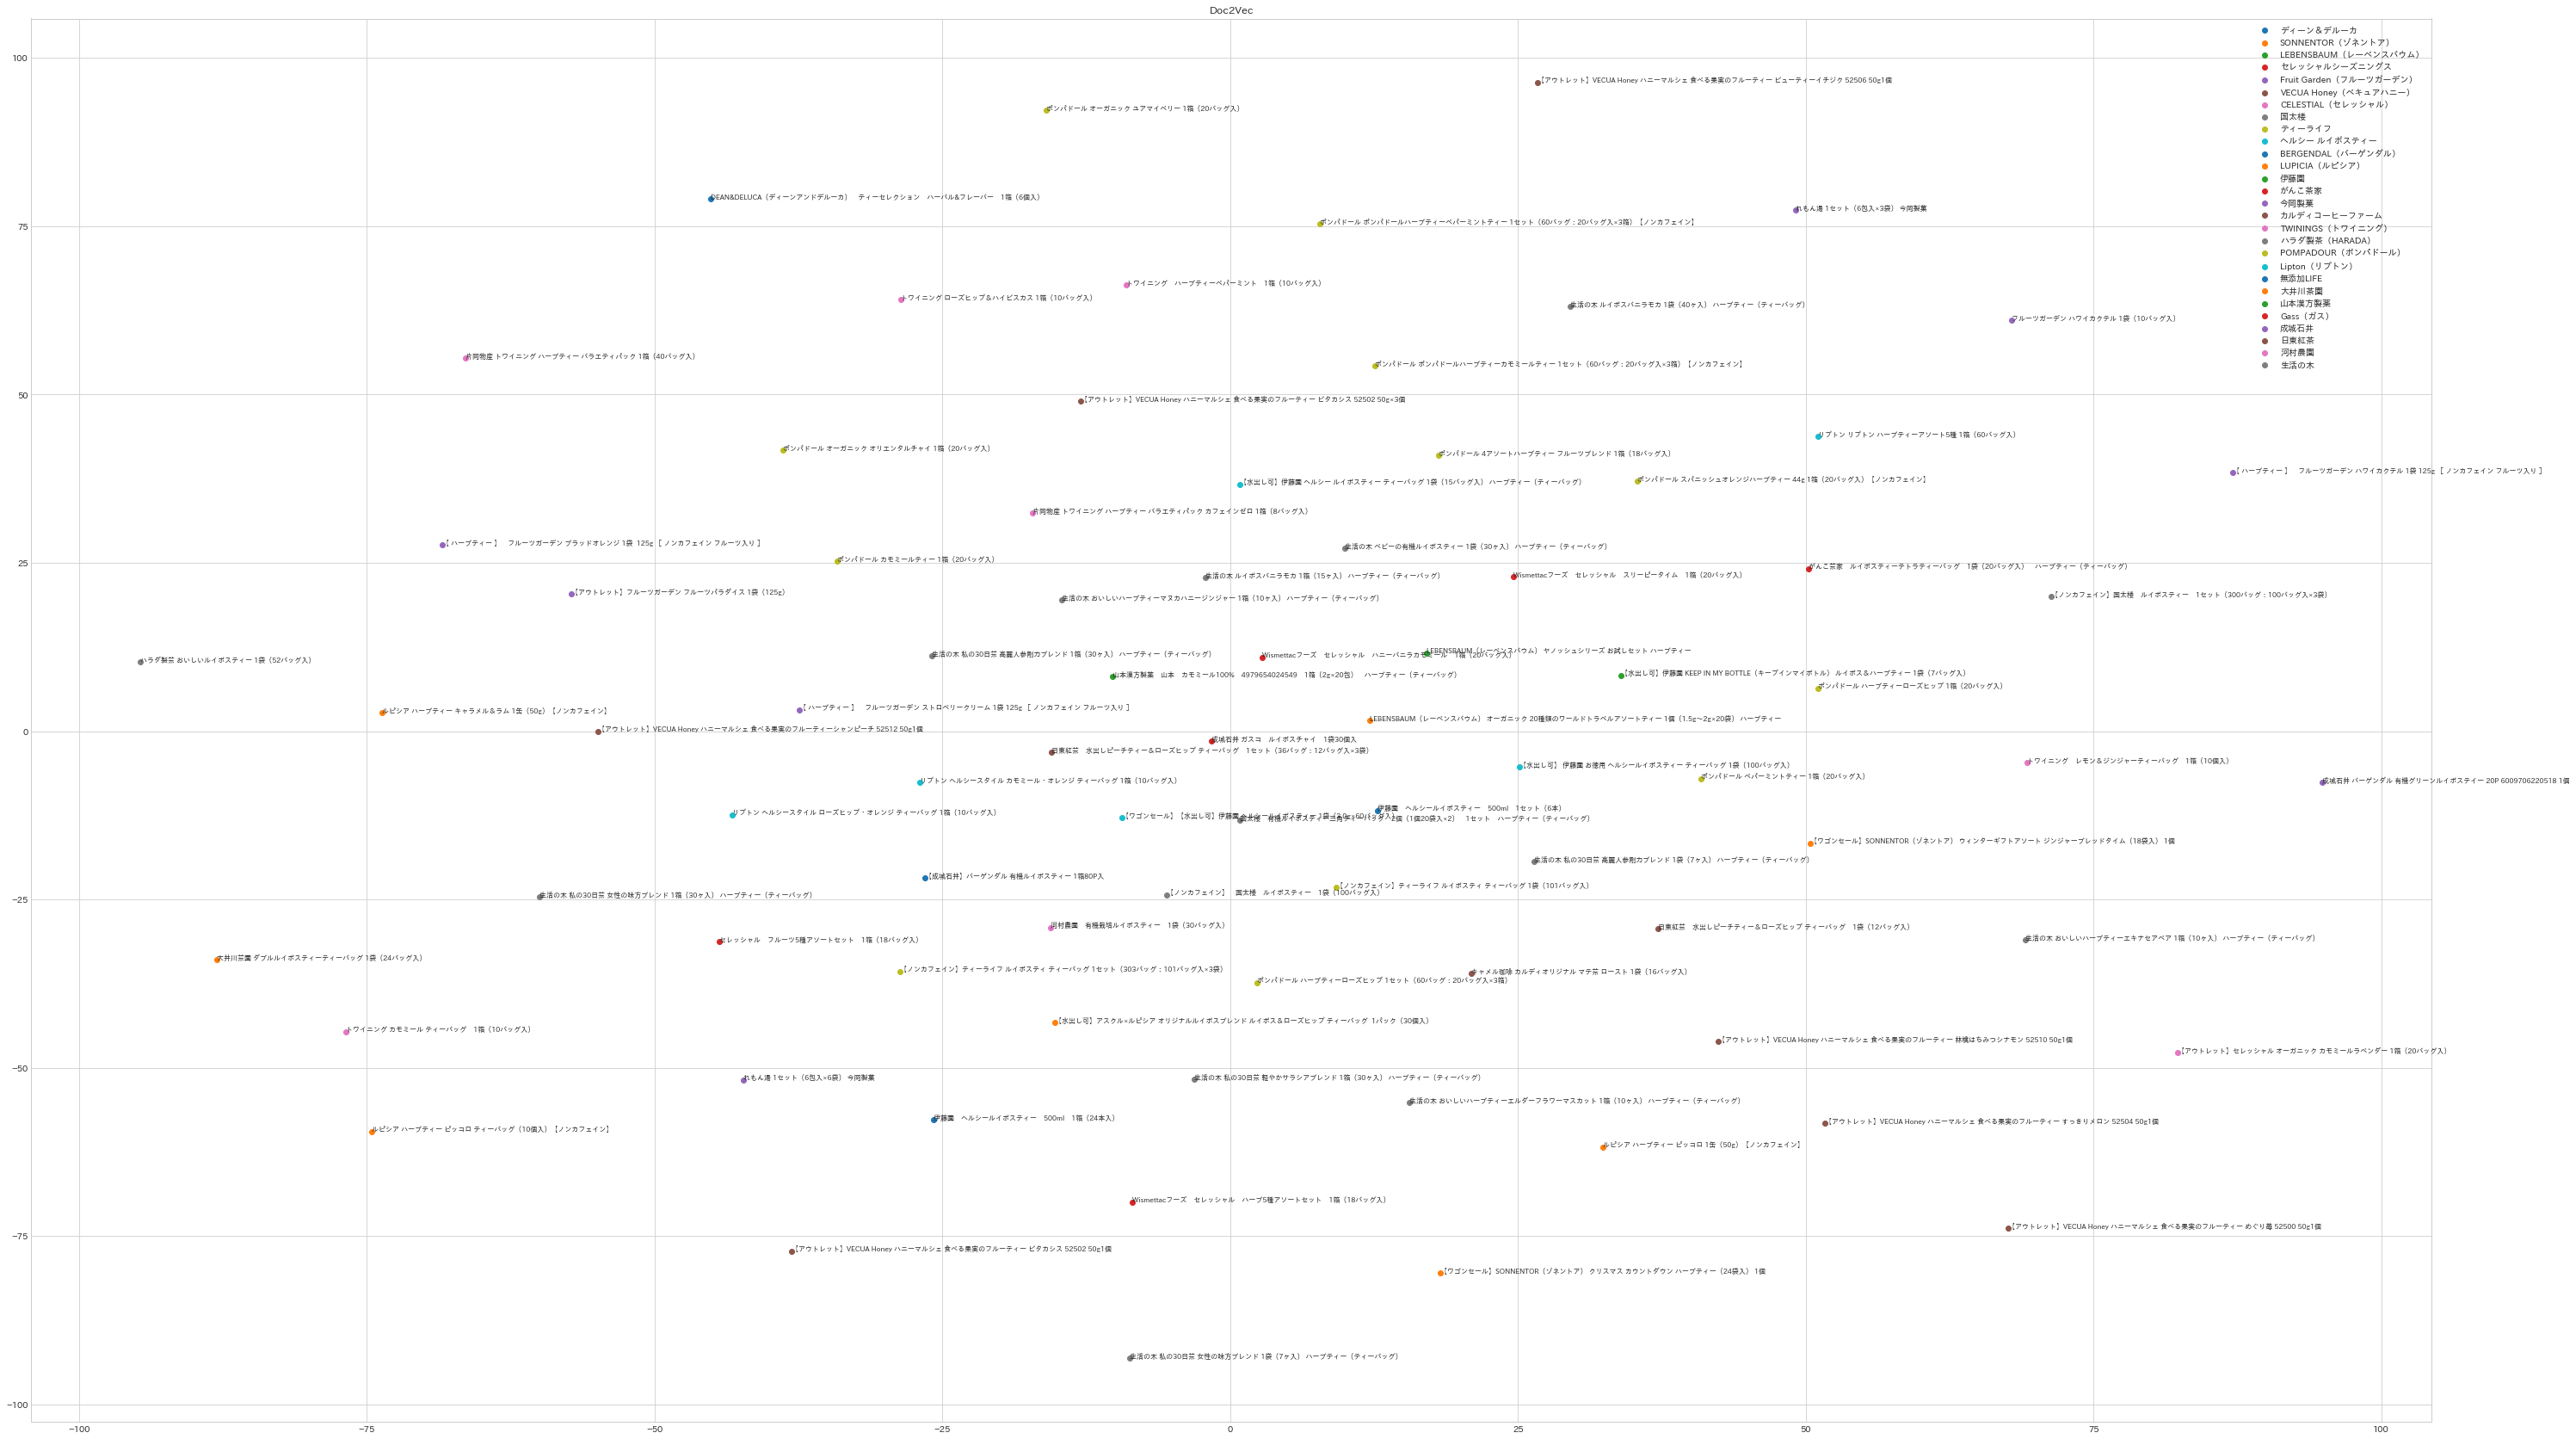

In [62]:
#Put in DataFrame
df_tsne_doc2vec = pd.DataFrame(tsne_doc2vec[:, 0],columns = ["x"])
df_tsne_doc2vec["y"] = pd.DataFrame(tsne_doc2vec[:, 1])
df_tsne_doc2vec["product_name"] = df_new_combined.product_name  
df_tsne_doc2vec["brand"] = df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_doc2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_doc2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Doc2Vec-overview-")

#B: Detail
fig_detail_doc2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_doc2vec["product_name"].values):
    plt.annotate(txt, (df_tsne_doc2vec["x"].values[i], df_tsne_doc2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Doc2Vec")

plt.show()